# CNN

In [1]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

C:\Users\ASUS\Miniconda3\envs\belajar_cv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BASE_DIR = "datasets/"
names = ["Mask", "No Mask"]

tf.random.set_seed(1)

In [3]:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [4]:
orig_folders = ["Mask/", "No Mask/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    numer_of_images = len([name for name in files])
    n_train = int((numer_of_images * 0.7) + 0.5)
    n_valid = int((numer_of_images * 0.15) + 0.5)
    n_test = numer_of_images - n_train - n_valid
    print(numer_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

208 146 31 31
131 92 20 19


In [3]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        rotation_range=20,
                                                        horizontal_flip=True,
                                                        vertical_flip=True,
                                                        zoom_range=0.2,
                                                        shear_range=0.2)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'datasets/train/',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    classes=names
)

val_batches = valid_gen.flow_from_directory(
    'datasets/val/',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'datasets/test/',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    classes=names
)

Found 236 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [4]:
class FaceMaskClassification_Model:
    def __init__(self):
        self.model = tf.keras.models.Sequential([
                  tf.keras.layers.Conv2D(32, (2,2), padding='same', activation='relu', input_shape=(224,224,3)),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Conv2D(16, (2,2), padding='same', activation='relu'),
                  tf.keras.layers.MaxPooling2D(),
                  
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(1024, activation='relu'),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(1024, activation='relu'),
                  tf.keras.layers.Dropout(0.4),
                  tf.keras.layers.Dense(512, activation='relu'),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(512, activation='relu'),
                  tf.keras.layers.Dropout(0.4),
                  tf.keras.layers.Dense(256, activation='relu'),
                  tf.keras.layers.Dropout(0.4),
                  tf.keras.layers.Dense(128, activation='relu'),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(1, activation='sigmoid'),
              ])
    def summary(self):
        return self.model.summary()
    def compile(self):
        return self.model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
    def fit(self):
        # Training
        epochs = 100

        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1
        )  

        history = self.model.fit(train_batches, validation_data=val_batches,callbacks=[early_stopping], epochs=epochs, verbose=1)
        return history
    def predict_single_img(self, src_img, img_width, img_height):
        # dimensions of our images
        img_width, img_height = img_width, img_height

        img = image.load_img(src_img, target_size=(img_width, img_height))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])
        classes = self.model.predict_classes(images, batch_size=10)

        label = names[classes[0]]

        plt.title(label)
        plt.imshow(img)
    def predict_multiple_img(self, test_img):
        i = 1
        plt.figure(figsize=(15,20))
        for images, labels in iter(test_img):
            id = np.random.randint(32)
            image = images[id]
            label = names[int(labels[id])]
            proba = self.model.predict(image[np.newaxis,...])
            pred = names[np.argmax(proba)]
            max_proba = float(max(proba[0]))

            font = {"color":"r"} if label != pred else {"color":"g"}
            plt.subplot(5,3,i)

            plt.imshow(image)
            plt.title(f"Label : {label}, Prediction : {pred}", fontdict=font)
            plt.axis('off')

            i+=1
            if i>=16:
                break

        plt.tight_layout()
        plt.show()

In [5]:
model = FaceMaskClassification_Model()

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              51381248  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [7]:
model.compile()

In [8]:
history = model.fit()

Epoch 1/100
8/8 [==============================] - 36s 4s/step - loss: 0.7098 - accuracy: 0.4746 - val_loss: 0.6714 - val_accuracy: 0.6078
Epoch 2/100
8/8 [==============================] - 26s 3s/step - loss: 0.6960 - accuracy: 0.5551 - val_loss: 0.6714 - val_accuracy: 0.6078
Epoch 3/100
8/8 [==============================] - 27s 3s/step - loss: 0.6422 - accuracy: 0.5975 - val_loss: 0.6681 - val_accuracy: 0.6078
Epoch 4/100
8/8 [==============================] - 26s 3s/step - loss: 0.6583 - accuracy: 0.6229 - val_loss: 0.6661 - val_accuracy: 0.6078
Epoch 5/100
8/8 [==============================] - 25s 3s/step - loss: 0.6559 - accuracy: 0.6102 - val_loss: 0.6684 - val_accuracy: 0.6078
Epoch 6/100
8/8 [==============================] - 22s 3s/step - loss: 0.6364 - accuracy: 0.5805 - val_loss: 0.6664 - val_accuracy: 0.6078
Epoch 7/100
8/8 [==============================] - 22s 3s/step - loss: 0.6678 - accuracy: 0.6017 - val_loss: 0.6643 - val_accuracy: 0.6078
Epoch 8/100
8/8 [==========

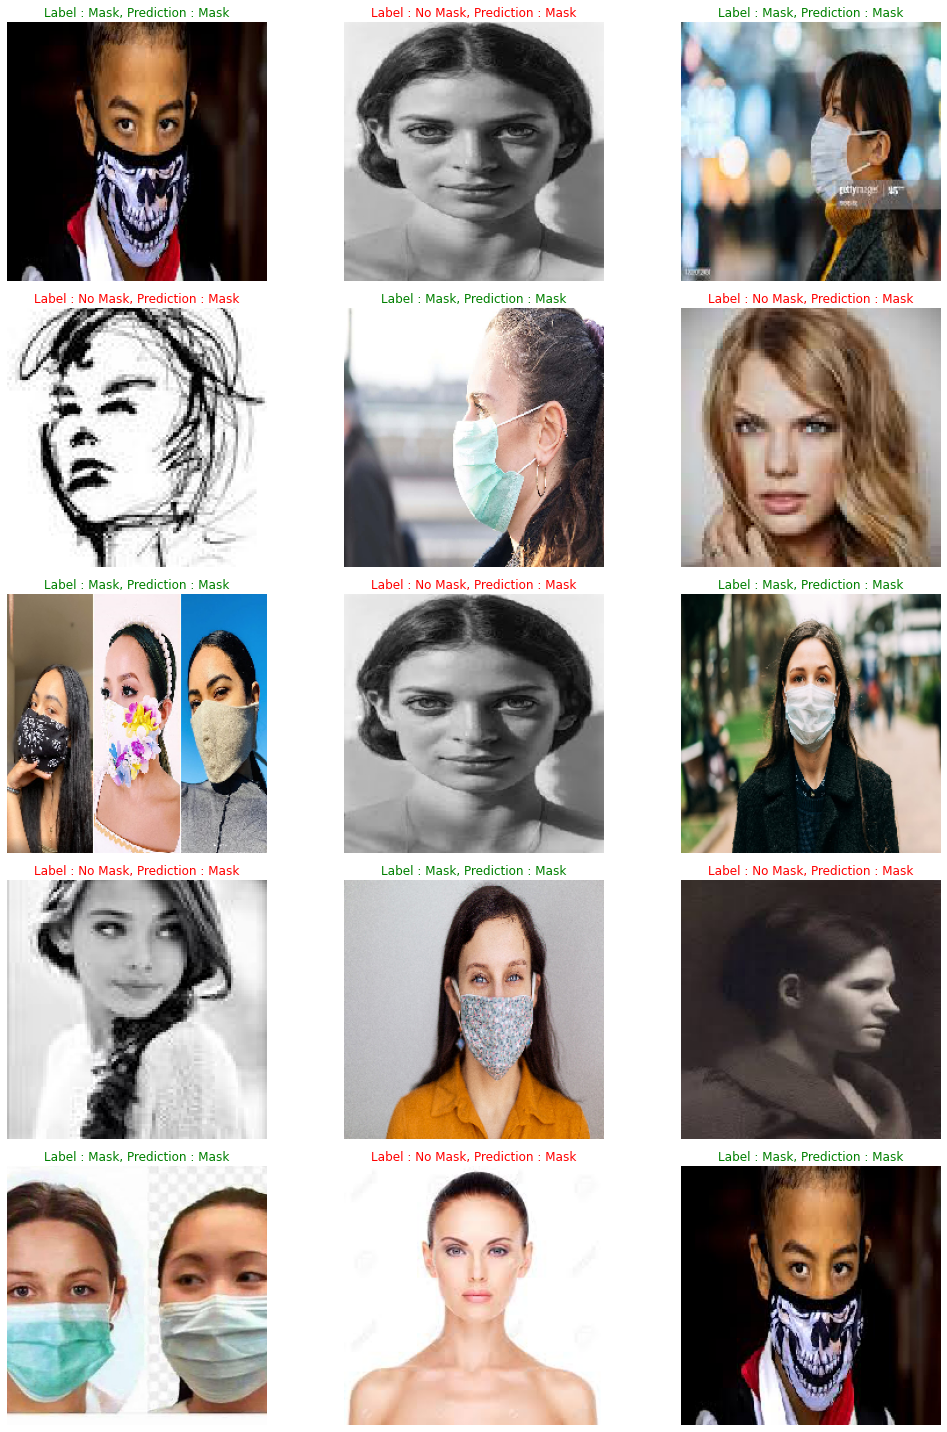

In [14]:
model.predict_multiple_img(test_batches)

# Transfer Larning

In [3]:
from tensorflow.keras.applications import ResNet50

resnet50_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")
print(type(resnet50_model))
resnet50_model.summary()

<class 'tensorflow.python.keras.engine.functional.Functional'>
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________

In [4]:
for layer in resnet50_model.layers:
    layer.trainable = False
resnet50_model.summary()    

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

resnet50_model = Sequential()
resnet50_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
resnet50_model.add(Dense(1, activation='sigmoid'))

In [6]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.0001)
metrics = ['accuracy']

resnet50_model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [7]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [8]:
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'datasets/train/',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    classes=names
)

val_batches = valid_gen.flow_from_directory(
    'datasets/val/',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'datasets/test/',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    classes=names
)

Found 236 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [9]:
# Training
epochs = 20

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)  

resnet50_histrory = resnet50_model.fit(train_batches, validation_data=val_batches,callbacks=[early_stopping], epochs=epochs, verbose=1)

Epoch 1/20
8/8 [==============================] - 199s 25s/step - loss: 0.6790 - accuracy: 0.7542 - val_loss: 0.5714 - val_accuracy: 0.9412
Epoch 2/20
8/8 [==============================] - 188s 23s/step - loss: 0.5641 - accuracy: 0.9619 - val_loss: 0.5442 - val_accuracy: 1.0000
Epoch 3/20
8/8 [==============================] - 220s 27s/step - loss: 0.5565 - accuracy: 0.9788 - val_loss: 0.5442 - val_accuracy: 1.0000
Epoch 4/20
8/8 [==============================] - 215s 27s/step - loss: 0.5573 - accuracy: 0.9746 - val_loss: 0.5442 - val_accuracy: 1.0000
Epoch 5/20
8/8 [==============================] - 212s 27s/step - loss: 0.5554 - accuracy: 0.9788 - val_loss: 0.5442 - val_accuracy: 1.0000
Epoch 6/20
8/8 [==============================] - 249s 31s/step - loss: 0.5543 - accuracy: 0.9831 - val_loss: 0.5442 - val_accuracy: 1.0000
Epoch 7/20
8/8 [==============================] - 277s 35s/step - loss: 0.5509 - accuracy: 0.9915 - val_loss: 0.5443 - val_accuracy: 1.0000
Epoch 8/20
8/8 [====

In [11]:
resnet50_model.evaluate(test_batches)

2/2 [==============================] - 3s 1s/step - loss: 0.5613 - accuracy: 0.9800


[0.5613406896591187, 0.9800000190734863]

# Save Model

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [14]:
resnet50_model.save("Model/model_FeceDetection_ResNet50.h5")
print('Model Saved')

Model Saved
